# CCD Reduction and Aperture Photometry
- Aliza Mustafa (aliza.mustafa@students.uniroma2.eu)
- Master in Astrophysics and Space Science (MASS)
- Department of Astronomy, Faculty of Maths, University of Belgrade
- This Jupyter notebook has been created to fulfil the requirements of the course "Data Analysis and Reduction Tecnhiques in Astronomy" taught by Prof. Dragana Ilic, 2023-2024.


In [1]:
import sys
import os
import numpy as np
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils import make_source_mask
from astropy.visualization import simple_norm, imshow_norm
from astropy import stats as astrostats
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
from photutils import BkgZoomInterpolator
from astropy.visualization import simple_norm

In [92]:
#Defining directory and files paths
path = "/Users/alizamustafa/Downloads/22_10_2023-copy"

bias_names = 'bias*.fit'
dark_200s_names = 'scDarkZalaz-200sec*.fit'
dark_5s_names = 'dark*5sec*.fit'
flats_names = 'flat*5sec*B*.fit' #B-filter
scinece_image_B='Mrk335*B.fit' #mrk335 B-filter
scinece_image_R='Mrk335*R.fit'
scinece_image_V='Mrk335*V.fit'
scinece_image_cnt='Mrk335*cnt.fit' #h-alpha continuum
scinece_image_SII='Mrk335*SII.fit'
scinece_image_ha='Mrk335*Ha.fit'
flat_names_R='flat*5sec*R.fit'
flat_names_V='flat*5sec*V.fit'
flat_names_SII='flat*5sec*SII.fit'
flat_names_cnt='flat*5sec*HaContinuum.fit'
flat_names_ha='flat*5sec*Ha.fit'



os.chdir(path)

# Basic CCD reduction process:
- Creating master bias, master flat and master dark frame (5s) for master flat and (200s) science images

In [3]:
#step 1:
# Creating Master Bias
biases = []
for file in glob.glob(bias_names):
    with fits.open(file) as hdul:
        biases.append(hdul[0].data)
biases = np.array(biases)
master_bias = np.median(biases, axis=0)
#fits.writeto('master_bias.fits', master_bias, overwrite=True)

# Creating master dark for 200s for science images
dark_200s = []
for file in glob.glob(dark_200s_names):
    with fits.open(file) as hdul:
        # Subtracting master bias from each dark frame
        dark_200s.append(hdul[0].data - master_bias)
dark_200s = np.array(dark_200s)
master_dark_200s = np.median(dark_200s, axis=0)
#fits.writeto('master_dark_200s.fits', master_dark_200s, overwrite=True)

# Creatinm master dark for 5s
dark_5s = []
for file in glob.glob(dark_5s_names):
    with fits.open(file) as hdul:
        # subtracting master bias from each dark frame
        dark_5s.append(hdul[0].data - master_bias)
dark_5s = np.array(dark_5s)
master_dark_5s = np.median(dark_5s, axis=0)
#fits.writeto('master_dark_5s.fits', master_dark_5s, overwrite=True)

#Master Flat for B-filter
flats = []
for file in glob.glob(flats_names):
    with fits.open(file) as hdul:
        # Subtracting master bias and dark current from each flat frame
        
        flats.append((hdul[0].data - master_bias) - master_dark_5s )
flats = np.array(flats)
master_flat = np.median(flats, axis=0) / np.median(flats)  # Normalizing the master flat
#fits.writeto('master_flat.fits', master_flat, overwrite=True)





In [4]:
#master flat for R filter
flats_R= []
for file in glob.glob(flat_names_R):
    with fits.open(file) as hdul:
        flats_R.append((hdul[0].data - master_bias) - master_dark_5s )
flats_R = np.array(flats)
master_flat_R = np.median(flats_R, axis=0) / np.median(flats_R)

#master flat for V filter
flats_V= []
for file in glob.glob(flat_names_V):
    with fits.open(file) as hdul:
        flats_V.append((hdul[0].data - master_bias) - master_dark_5s )
flats_V = np.array(flats)
master_flat_V = np.median(flats_V, axis=0) / np.median(flats_V)

#master flat for cnt filter
flats_cnt= []
for file in glob.glob(flat_names_cnt):
    with fits.open(file) as hdul:
        flats_cnt.append((hdul[0].data - master_bias) - master_dark_5s )
flats_cnt = np.array(flats)
master_flat_cnt = np.median(flats_cnt, axis=0) / np.median(flats_cnt)

#master flat for ha filter
flats_ha= []
for file in glob.glob(flat_names_ha):
    with fits.open(file) as hdul:
        flats_ha.append((hdul[0].data - master_bias) - master_dark_5s )
flats_ha = np.array(flats)
master_flat_ha= np.median(flats_ha, axis=0) / np.median(flats_ha)


#master flat for SII filter
flats_s= []
for file in glob.glob(flat_names_SII):
    with fits.open(file) as hdul:
        flats_s.append((hdul[0].data - master_bias) - master_dark_5s )
flats_s = np.array(flats)
master_flat_s= np.median(flats_s, axis=0) / np.median(flats_s)

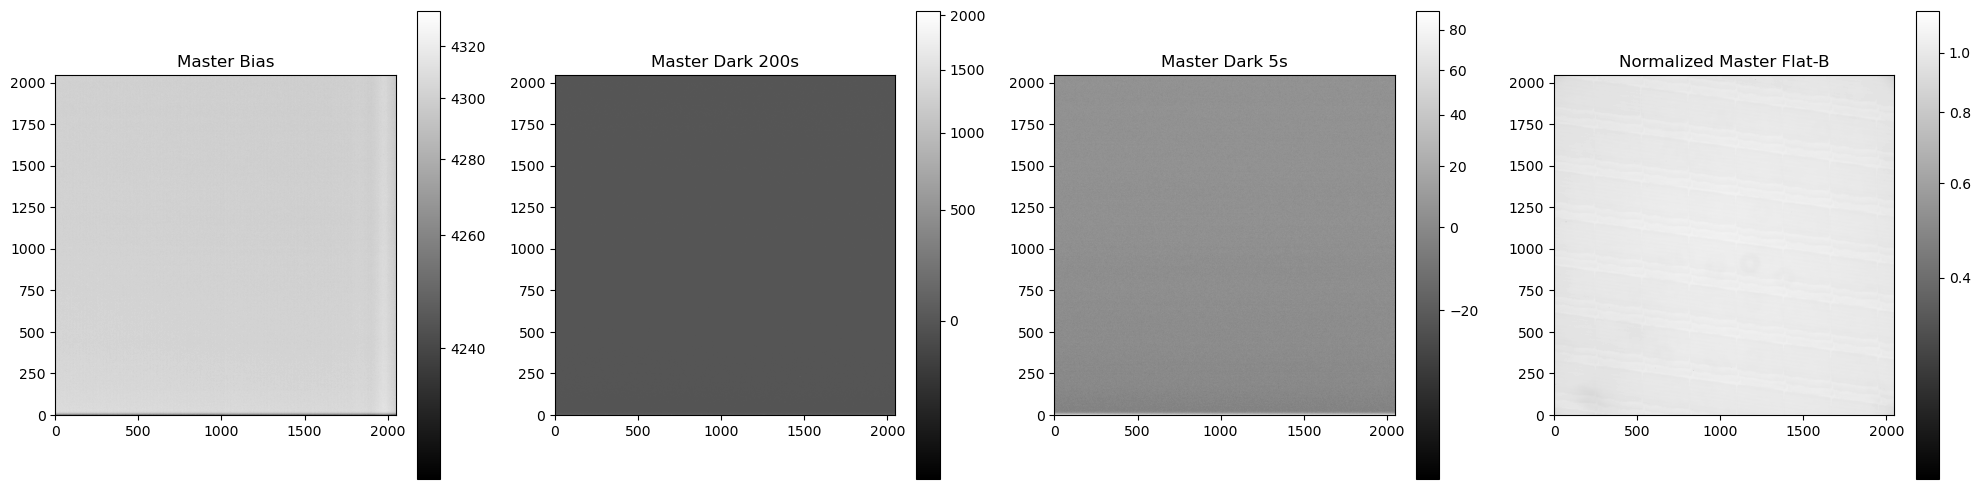

In [5]:
#displaying the master files 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

norm_bias = simple_norm(master_bias, 'sqrt')
im_bias = axs[0].imshow(master_bias, cmap='gray', norm=norm_bias, origin='lower')
fig.colorbar(im_bias, ax=axs[0])
axs[0].set_title('Master Bias')

norm_dark_200s = simple_norm(master_dark_200s, 'sqrt')
im_dark_200s = axs[1].imshow(master_dark_200s, cmap='gray', norm=norm_dark_200s, origin='lower')
fig.colorbar(im_dark_200s, ax=axs[1])
axs[1].set_title('Master Dark 200s')

norm_dark_5s = simple_norm(master_dark_5s, 'sqrt')
im_dark_5s = axs[2].imshow(master_dark_5s, cmap='gray', norm=norm_dark_5s, origin='lower')
fig.colorbar(im_dark_5s, ax=axs[2])
axs[2].set_title('Master Dark 5s')

norm_flat = simple_norm(master_flat, 'sqrt')
im_flat = axs[3].imshow(master_flat, cmap='gray', norm=norm_flat, origin='lower')
fig.colorbar(im_flat, ax=axs[3])
axs[3].set_title('Normalized Master Flat-B')


plt.tight_layout()
plt.show()

# Calibration Process:
- Dividing by normalized flat field to ensure that the correction does not alter the overall flux scale of the science image but only corrects the relative response of each pixel.
$$\text{Corrected Image} = \frac{(\text{Raw Science Image} - \text{Bias}) - (\text{Dark} \times \frac{\text{Exposure Time of Raw Image}}{\text{Exposure Time of Dark Frame}})}{\text{Normalized Flat}}$$



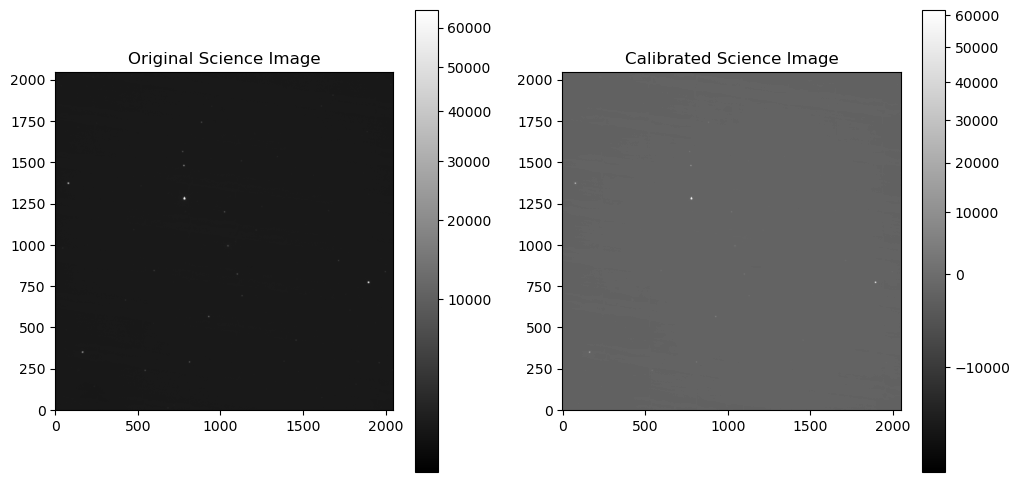

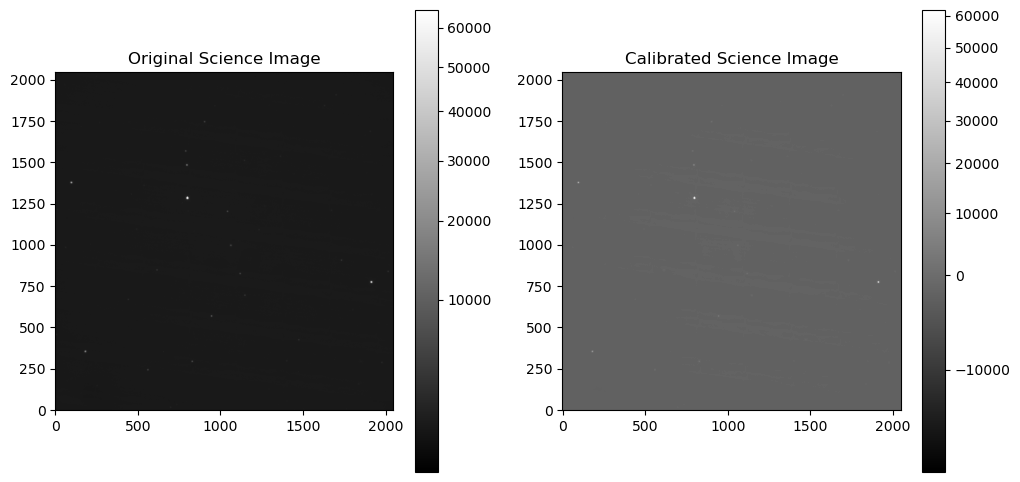

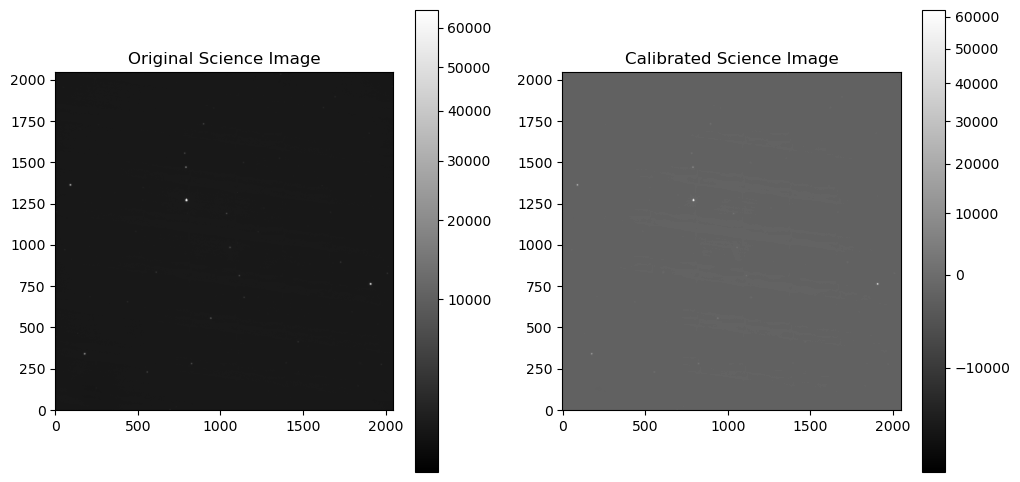

In [39]:
science_image_B = 'Mrk335*B.fit' #B-filter
for file in glob.glob(science_image_B):
    with fits.open(file) as hdul:  # Using the file variable here
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat
        
        
        calibrated_filename = f'335-B-calibration_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image')

        plt.show()


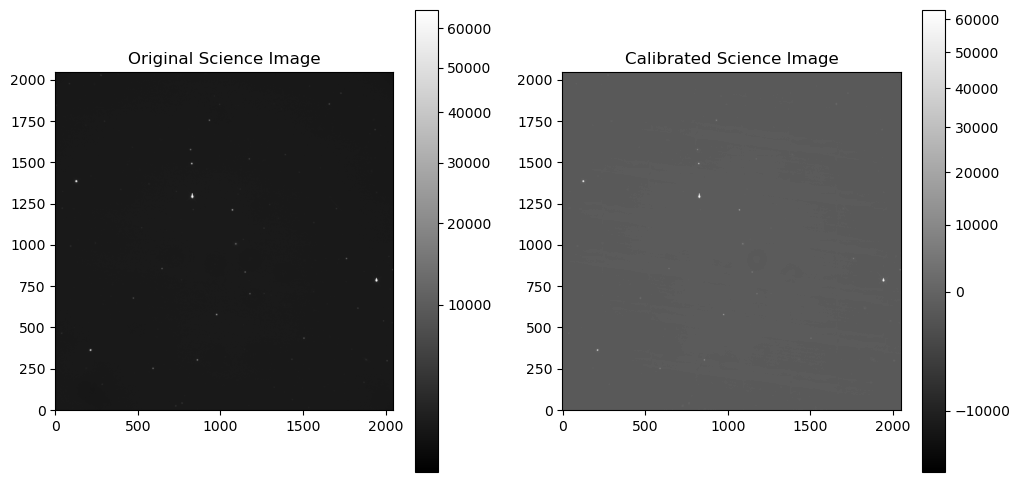

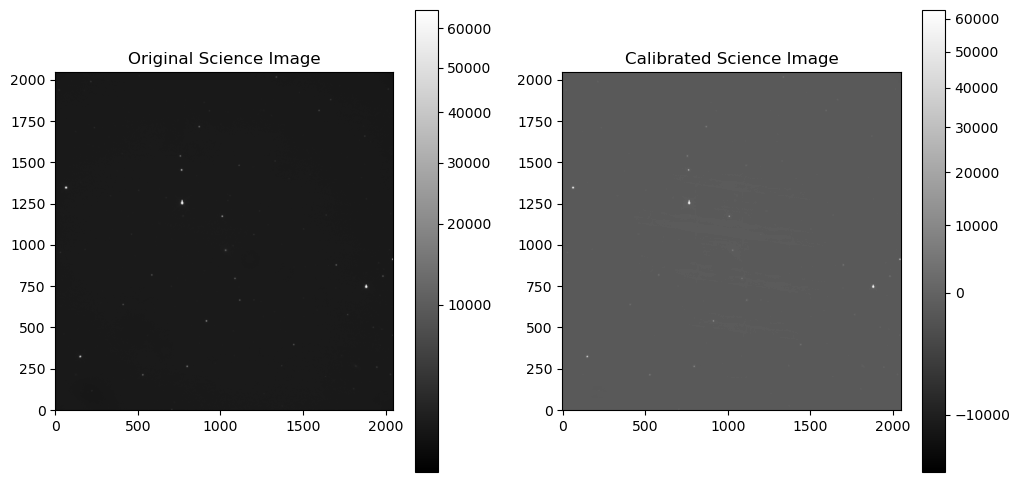

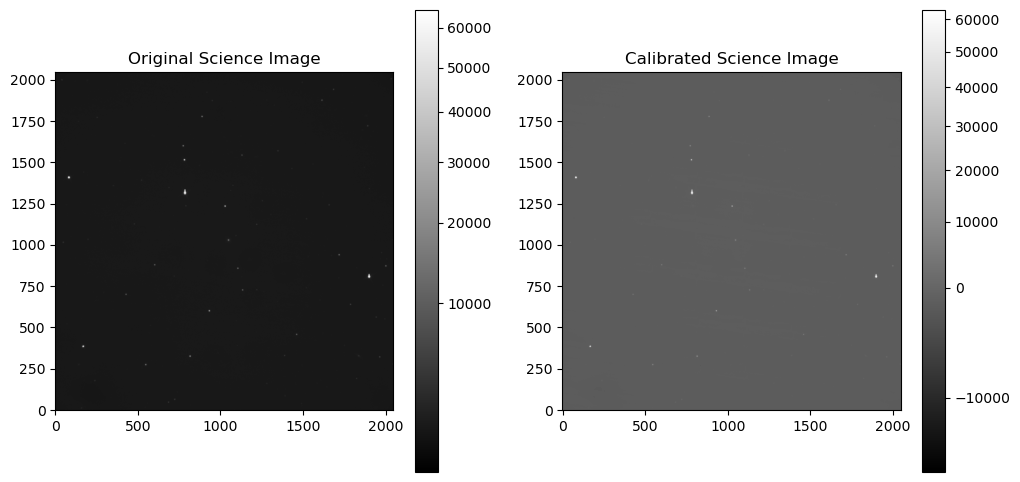

In [6]:
science_image_R = 'Mrk335*R.fit'
for file in glob.glob(science_image_R):
    with fits.open(file) as hdul:  
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat_R
        
        
        calibrated_filename = f'335-R-calib_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image')

        plt.show()


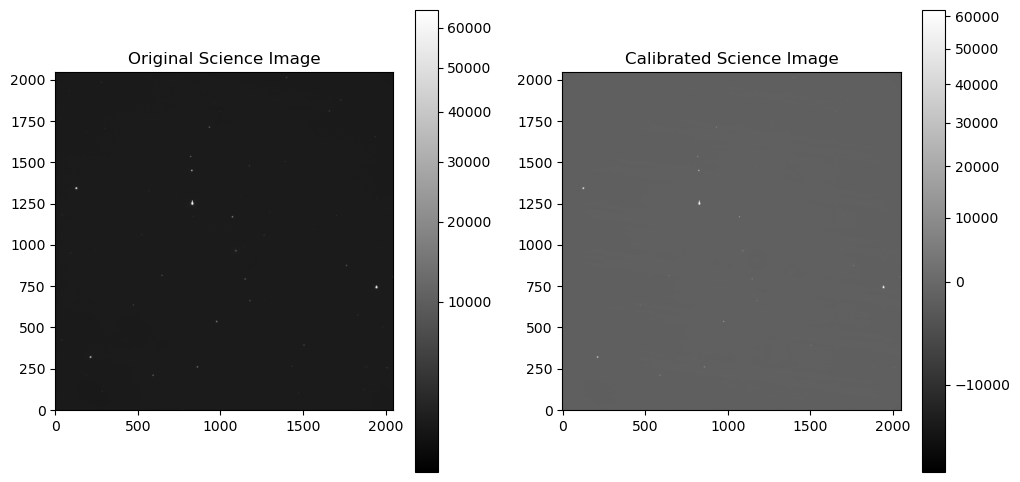

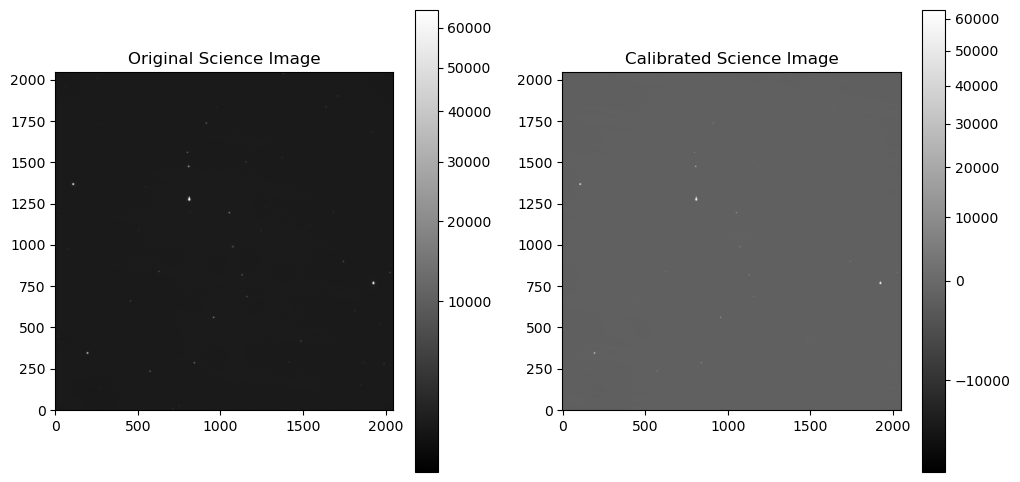

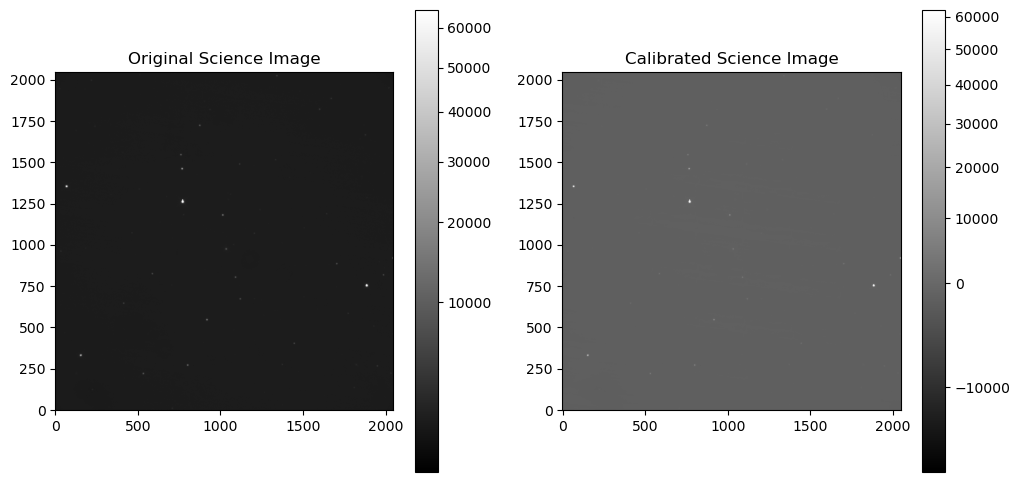

In [36]:
science_image_V = 'Mrk335*V.fit'  #V-filter
for file in glob.glob(science_image_V):
    with fits.open(file) as hdul:  
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat_V
        
        
        calibrated_filename = f'335-V-calib_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image')

        plt.show()

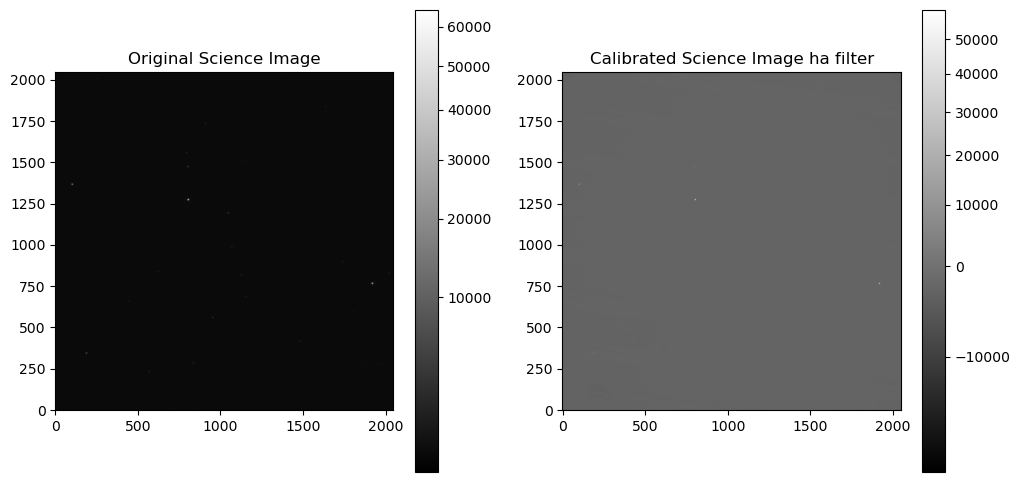

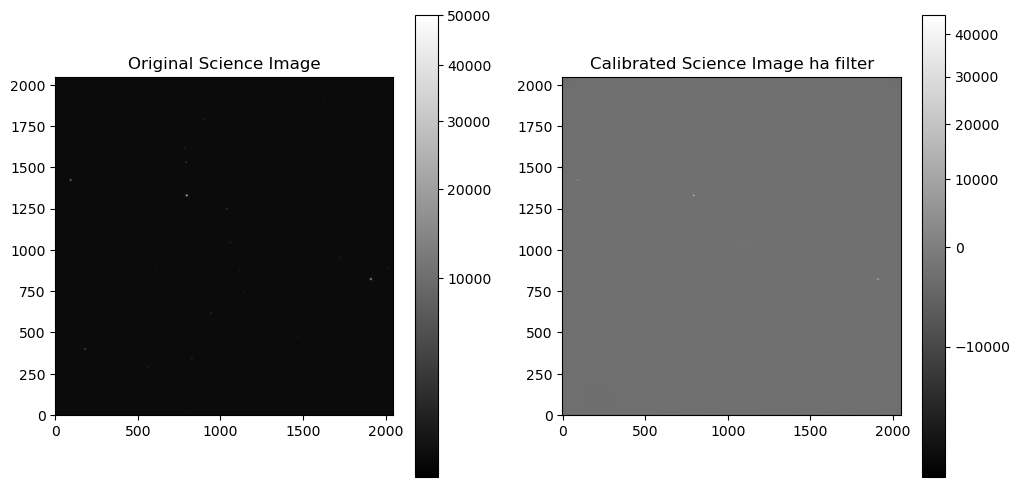

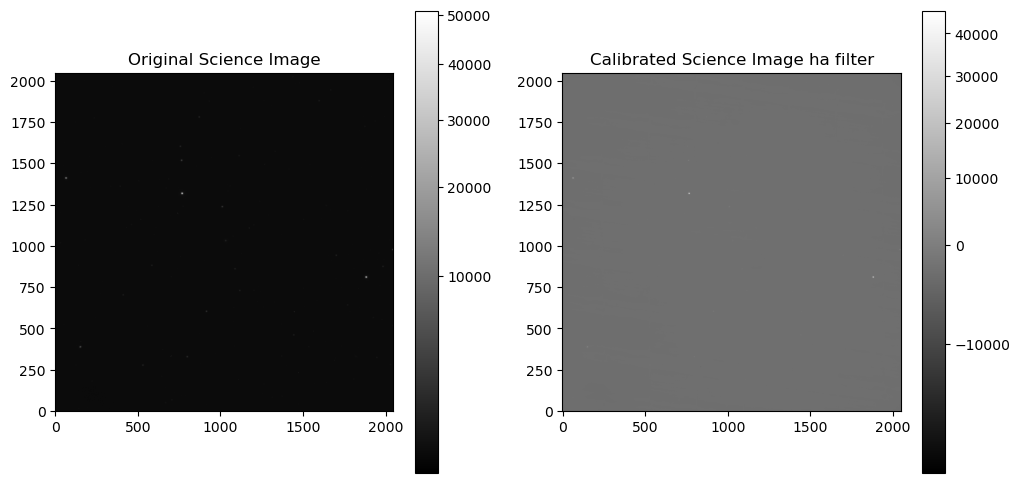

In [93]:
#ha-filter
for file in glob.glob(scinece_image_ha):
    with fits.open(file) as hdul:  
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat_ha
        
        
        calibrated_filename = f'335-V-calib_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image ha filter')

        plt.show()

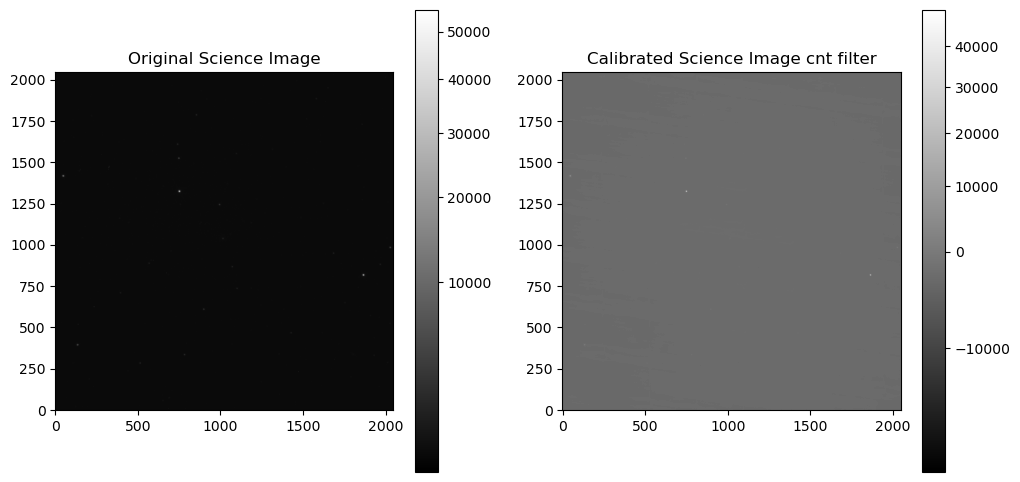

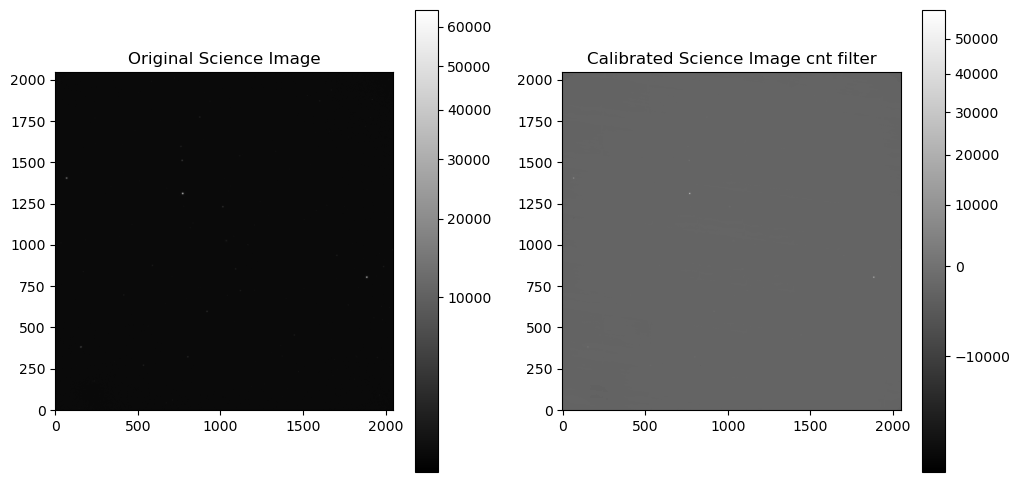

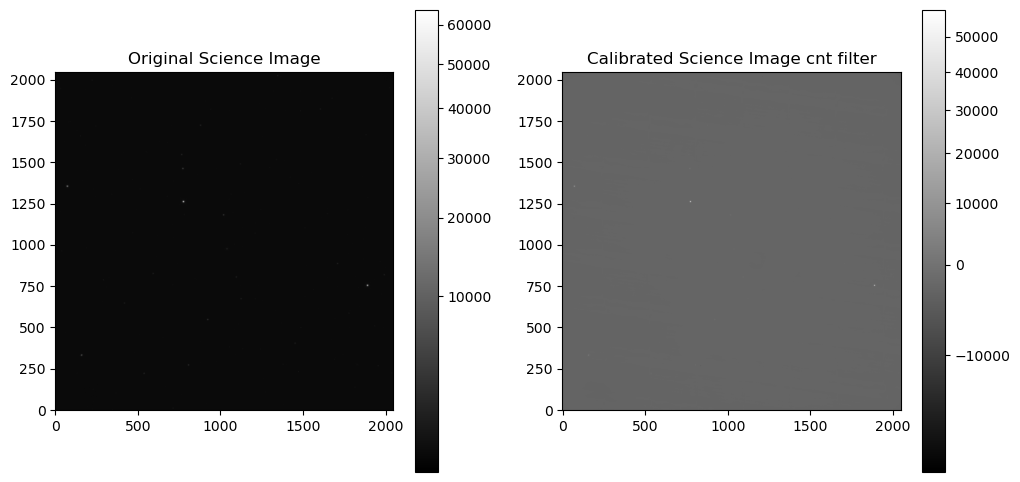

In [94]:
#cnt-filter
for file in glob.glob(scinece_image_cnt):
    with fits.open(file) as hdul:  
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat_cnt
        
        
        calibrated_filename = f'335-V-calib_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image cnt filter')

        plt.show()

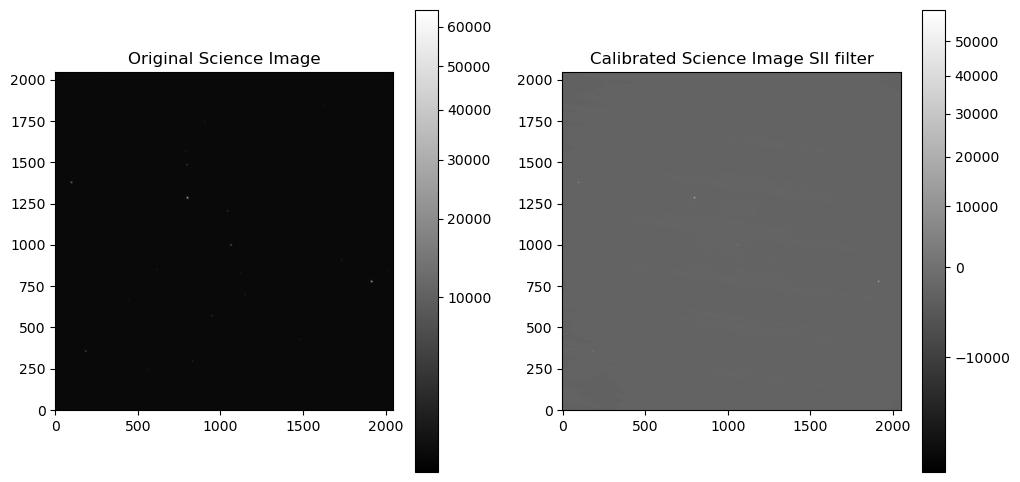

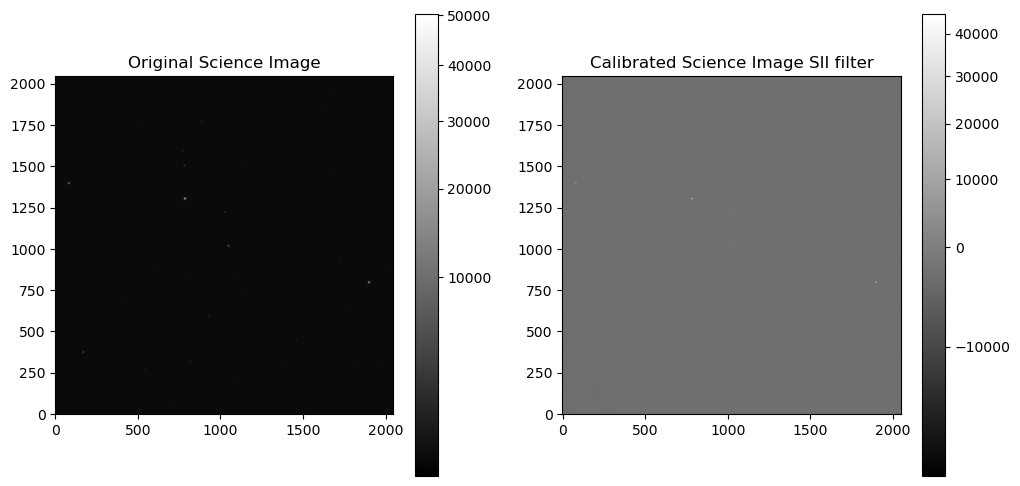

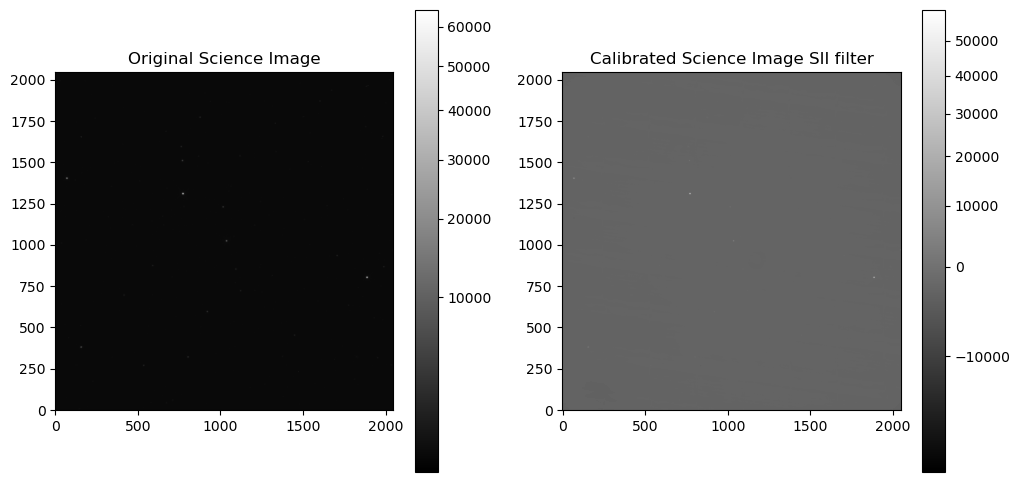

In [96]:
#SII-filter
for file in glob.glob(scinece_image_SII):
    with fits.open(file) as hdul:  
        hdu = hdul[0]
        original_data = hdu.data.copy()
        exptime = hdu.header['EXPOSURE']

        # Calibrating the data
        calibrated_data = (original_data - master_bias - (master_dark_200s / 200) * exptime) / master_flat_s
        
        
        calibrated_filename = f'335-V-calib_{file.split(".")[0].split("*")[-1]}.fits'
        fits.writeto(calibrated_filename, calibrated_data, hdul[0].header, overwrite=True)

        plt.figure(figsize=(12, 6))

        # Original Science Image
        plt.subplot(1, 2, 1)
        norm1 = simple_norm(original_data, 'sqrt')
        plt.imshow(original_data, cmap='gray', origin='lower', norm=norm1)
        plt.colorbar()
        plt.title('Original Science Image')

        # Calibrated Science Image
        plt.subplot(1, 2, 2)
        norm2 = simple_norm(calibrated_data, 'sqrt')
        plt.imshow(calibrated_data, cmap='gray', origin='lower', norm=norm2)
        plt.colorbar()
        plt.title('Calibrated Science Image SII filter')

        plt.show()

## Stacking 3 science images of Mrk335 for B, R and V filter

In [15]:
import astroalign as aa
import ccdproc
from astropy.nddata import CCDData, NDData
from astropy import units as u
from astropy.wcs import WCS
from pathlib import Path

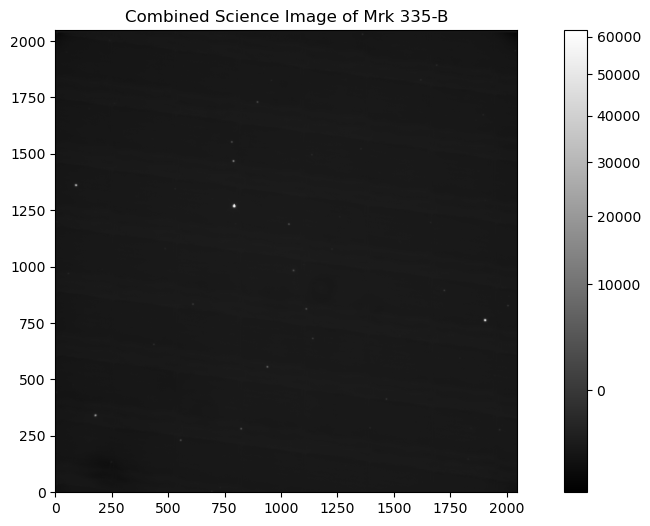

In [98]:
directory_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy')
file_pattern = '335*B*calibration*.fits'
file_paths = list(directory_path.glob(file_pattern))
aligned_images = []  #initialized to store the data later on
reference_image = None
reference_wcs = None

# Processing each file
for file_path in file_paths:
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    if data.dtype.byteorder == '>':   #to deal with the error: "Big-endian buffer not supported on little-endian compiler"
        data = data.byteswap().newbyteorder()

    ccd = CCDData(data, meta=header, unit='adu') #extracting data from the header
    wcs_info = WCS(header)  #contains WCS information extracted from the FITS header
    #which is necessary for aligning the images based on celestial coordinates.



    # aligning images
    if reference_image is None:
        reference_image = ccd
        reference_wcs = wcs_info    
        aligned_images.append(ccd)
    else:
        try:
            aligned_data, _ = aa.register(ccd, reference_image)
            aligned_ccd = CCDData(aligned_data, wcs=wcs_info, unit='adu')
            aligned_images.append(aligned_ccd)
        except aa.MaxIterError:
            print(f"alignment failed for {file_path}")

# Combining the aligned images using median combine
combiner = ccdproc.Combiner(aligned_images)
combined_image = combiner.median_combine()

# Converting the combined image data back into a CCDData object, which includes the WCS information of the reference image
combined_ccd = CCDData(combined_image, wcs=reference_wcs, unit='adu') 

# Saving the combined image
combined_image_path = directory_path / 'comb-335-B-1.fit'
combined_ccd.write(combined_image_path, overwrite=True)

combined_image_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-B-1.fit')

#display
with fits.open(combined_image_path) as hdul:
    data = hdul[0].data


plt.figure(figsize=(12, 6))
norm = simple_norm(data, 'sqrt')
plt.imshow(data, cmap='gray',origin='lower', norm=norm)
plt.colorbar()
plt.title('Combined Science Image of Mrk 335-B')
plt.show()

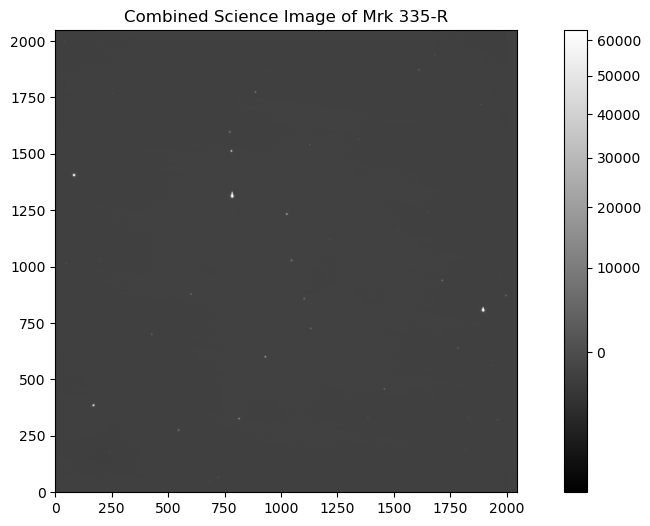

In [43]:
#repating same process as above for R and V filter
directory_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy')
file_pattern = '335*R*calib*.fits'
file_paths = list(directory_path.glob(file_pattern))
aligned_R = []
reference_image = None
reference_wcs = None


for file_path in file_paths:
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    if data.dtype.byteorder == '>':
        data = data.byteswap().newbyteorder()

    ccd = CCDData(data, meta=header, unit='adu')
    wcs_info = WCS(header)

    # Aligning images
    if reference_image is None:
        reference_image = ccd
        reference_wcs = wcs_info
        aligned_images.append(ccd)
    else:
        try:
            aligned_data, _ = aa.register(ccd, reference_image)
            aligned_ccd = CCDData(aligned_data, wcs=wcs_info, unit='adu')
            aligned_R.append(aligned_ccd)
        except aa.MaxIterError:
            print(f"Alignment failed for {file_path}")

# Combining the aligned images using median combine
combiner = ccdproc.Combiner(aligned_R)
combined_image = combiner.median_combine()

# Converting NDData back to CCDData for saving
combined_ccd = CCDData(combined_image, wcs=reference_wcs, unit='adu')

# Saving the combined image
combined_image_path = directory_path / 'comb-335-R.fit'
combined_ccd.write(combined_image_path, overwrite=True)
combined_image_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-R.fit')


with fits.open(combined_image_path) as hdul:
    data = hdul[0].data


plt.figure(figsize=(12, 6))
norm = simple_norm(data, 'sqrt')
plt.imshow(data, cmap='gray',origin='lower', norm=norm)
plt.colorbar()
plt.title('Combined Science Image of Mrk 335-R')
plt.show()

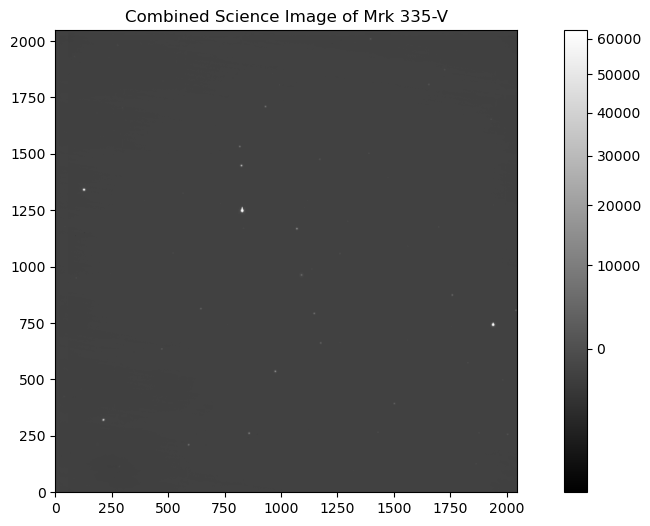

In [34]:
directory_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy')
file_pattern = '335*V*calib*.fits'
file_paths = list(directory_path.glob(file_pattern))
aligned_V = []
reference_image = None
reference_wcs = None


for file_path in file_paths:
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    if data.dtype.byteorder == '>':
        data = data.byteswap().newbyteorder()

    ccd = CCDData(data, meta=header, unit='adu')
    wcs_info = WCS(header)

    
    if reference_image is None:
        reference_image = ccd
        reference_wcs = wcs_info
        aligned_images.append(ccd)
    else:
        try:
            aligned_data, _ = aa.register(ccd, reference_image)
            aligned_ccd = CCDData(aligned_data, wcs=wcs_info, unit='adu')
            aligned_V.append(aligned_ccd)
        except aa.MaxIterError:
            print(f"Alignment failed for {file_path}")

#Combinig
combiner = ccdproc.Combiner(aligned_V)
combined_image = combiner.median_combine()

#Converting NDData back to CCDData for saving
combined_ccd = CCDData(combined_image, wcs=reference_wcs, unit='adu')


combined_image_path = directory_path / 'comb-335-V.fit'
combined_ccd.write(combined_image_path, overwrite=True)
combined_image_path = Path('/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-V.fit')


with fits.open(combined_image_path) as hdul:
    data = hdul[0].data


plt.figure(figsize=(12, 6))
norm = simple_norm(data, 'sqrt')
plt.imshow(data, cmap='gray',origin='lower', norm=norm)
plt.colorbar()
plt.title('Combined Science Image of Mrk 335-V')
plt.show()

## Astrometric Calibration
1- I'm using https://nova.astrometry.net to obtain astrometric solution so I can use standard srars for crossmatching purposes later on

In [44]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils import aperture_photometry, CircularAperture, DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from astropy.stats import sigma_clipped_stats


# Method:

For any star, the difference between the calibrated magnitude, $m$, and the above-atmosphere instrumental magnitude $m_{0,i}$ is given by:

$$ m = m_{0,i} + m_{zp}$$

where $m_{zp}$ is known as the zero point. The above-atmosphere instrumental magnitude is given by:

$$m_{0,i} = m_i - kX$$

where $m_i = -2.5 \log_{10}( Flux)$ is the instrumental magnitude,$k $is the extinction coefficient, and $X$ is the airmass. Therefore:

$$ m = m_i - kX + m_{zp}$$

So, by plotting the calibrated magnitude $ m$ against instrumental magnitude $ m_i$ for all the standard stars in the same FOV of our image, we would expect a straight line, with a gradient of one, and an intercept (offset) equal to $ kX + m_{zp}$. This intercept could then be added to all of our instrumental magnitudes to produce calibrated magnitudes.



In [45]:
# Defining the position for aperture photometry

fits_file = '/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-B.fit'  
with fits.open(fits_file) as hdul:
    data = hdul[0].data 
positions = [(1059.41, 982.52)] #retreived them from ds9 for mrk335

# Defining the target aperture and an annulus for background estimation
aperture = CircularAperture(positions, r=5.76)  # r=aperture radius 1.5* fwhm(1.5as=3.84 pixels)
annulus_aperture = CircularAnnulus(positions, r_in=7.68, r_out=11.52)  # r_in=2*FWHM(PIXELS) and r_out=3*FWHM(PIXELS) 

# Performing aperture photometry on the target
phot_table = aperture_photometry(data, aperture)

# Performing AP on the annulus to measure the background
annulus_phot_table = aperture_photometry(data, annulus_aperture)

# Calculating the mean background level (per pixel) in the annulus
# and then scaling it to the same size as the aperture
bkg_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area
bkg_sum = bkg_mean * aperture.area

# Subtracting the background from the aperture sum
phot_table['aperture_sum_bkg_subtracted'] = phot_table['aperture_sum'] - bkg_sum
print(phot_table['aperture_sum_bkg_subtracted'])


aperture_sum_bkg_subtracted
---------------------------
         187779.09269788387


The instrumental magnitude of an astronomical object is calculated using the formula:

$$m_i = -2.5 \log_{10}(Flux) $$
where flux is number of counts/exposure time

In [46]:
aperture_sum=phot_table['aperture_sum_bkg_subtracted']
instrumental_magnitude = -2.5 * np.log10(aperture_sum)
print("Instrumental magnitude:", instrumental_magnitude)

Instrumental magnitude: aperture_sum_bkg_subtracted
---------------------------
        -13.184118090812973


In [54]:
pixel_scale = 0.39 #0.39arcsec/pix (pic; 13.3' x13.3')
pixel_arcsec=2.56 #1pix=0.39as and 1.5as=2.56pix
fwhm_pixel=2.56*1.5 #aperture size
r_in=2*fwhm_pixel
r_out=fwhm_pixel*3
print(fwhm_pixel , r_in, r_out)

3.84 7.68 11.52


In [47]:
radii = [3.8, 7.6,
  11.5,
  19.2,
  26.9,
  30.7]  #in pixels accounting for seeing
#fwhm=1.5 arcsec
#1pix=0.39 arcsec
# Performing aperture photometry for multiple radii and subtract the background
for r in radii:
    aperture = CircularAperture(positions, r=r)
    annulus_aperture = CircularAnnulus(positions, r_in=2*r, r_out=3*r)
    annulus_masks = annulus_aperture.to_mask(method='center')

    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0]  # Exclude masked pixels
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)

    phot_table = aperture_photometry(data, aperture)
    bkg_median = np.array(bkg_median)
    phot_table['aperture_sum_bkg_subtracted'] = phot_table['aperture_sum'] - bkg_median * aperture.area

    print(f"radius= {r} pixels:")
    print(phot_table)
    print("\n" + "-"*80 + "\n")


radius= 3.8 pixels:
 id xcenter ycenter    aperture_sum    aperture_sum_bkg_subtracted
      pix     pix                                                 
--- ------- ------- ------------------ ---------------------------
  1 1059.41  982.52 18223.475402218442          124428.21776697019

--------------------------------------------------------------------------------

radius= 7.6 pixels:
 id xcenter ycenter     aperture_sum    aperture_sum_bkg_subtracted
      pix     pix                                                  
--- ------- ------- ------------------- ---------------------------
  1 1059.41  982.52 -204108.81230045517           237175.1151717712

--------------------------------------------------------------------------------

radius= 11.5 pixels:
 id xcenter ycenter    aperture_sum    aperture_sum_bkg_subtracted
      pix     pix                                                 
--- ------- ------- ------------------ ---------------------------
  1 1059.41  982.52 -742667.6911

In [48]:
#trying different aperture sizes
for r in radii:
    instrumental_magnitude = -2.5 * np.log10(phot_table['aperture_sum_bkg_subtracted'])

    print(f"radius= {r} pixels:")
    print(instrumental_magnitude )
    print("\n" + "-"*80 + "\n")


radius= 3.8 pixels:
aperture_sum_bkg_subtracted
---------------------------
        -13.700736294695181

--------------------------------------------------------------------------------

radius= 7.6 pixels:
aperture_sum_bkg_subtracted
---------------------------
        -13.700736294695181

--------------------------------------------------------------------------------

radius= 11.5 pixels:
aperture_sum_bkg_subtracted
---------------------------
        -13.700736294695181

--------------------------------------------------------------------------------

radius= 19.2 pixels:
aperture_sum_bkg_subtracted
---------------------------
        -13.700736294695181

--------------------------------------------------------------------------------

radius= 26.9 pixels:
aperture_sum_bkg_subtracted
---------------------------
        -13.700736294695181

--------------------------------------------------------------------------------

radius= 30.7 pixels:
aperture_sum_bkg_subtracted
-------------

## Aperture Photometry for B-band
- Firstly, I used the aperture photometry tool (https://www.aperturephotometry.org/) using the tutorial giver here: https://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/p05/ to obtain the instrumental magnitude of the standard stars from the calibrated science image of B, V and R filters separately.
- Once can define the aperture slice and the tool detects the sources automatically and provides a list of instrumental magnitude of the detected sources
- Secondly, I uploaded the obtained instrumental mag results along with the ApertureRA, and ApertureDec onto TOPCAT and positional cross-matched the objects within 0.5 as with the "Gaia DR3 Synthetic Photometry" catalogue to obtain the B-band magnitudes within the same FOV (13.3' x13.3')
- FWHM=1.5as for MRK335, roughly 4 pixels.

In [56]:
import pandas as pd
df=pd.read_csv('aperture_photometry.csv') #ra and dec in decimal degree
df

,ApertureRA,ApertureDec,Magnitude,RAdeg,DEdeg,Bmag
0,1.639485,20.284403,-13.1040,1.639473,20.284443,15.574613
1,1.608487,20.278941,-13.3995,1.608451,20.279025,15.287444
2,1.683031,20.272372,-14.9314,1.682993,20.272230,13.733124
3,1.594890,20.249251,-13.7985,1.594973,20.249377,14.881956
4,1.574951,20.221432,-13.2043,1.574914,20.221500,15.461921
5,1.581376,20.202882,-13.2514,1.581405,20.202949,14.913655
6,1.583745,20.180664,-13.2840,1.583729,20.180644,15.400573
7,1.692545,20.161690,-15.3754,1.692656,20.161691,13.336479
8,1.612056,20.150274,-14.5099,1.612092,20.150182,14.182531
9,1.612836,20.141177,-13.1898,1.612889,20.141011,15.492718


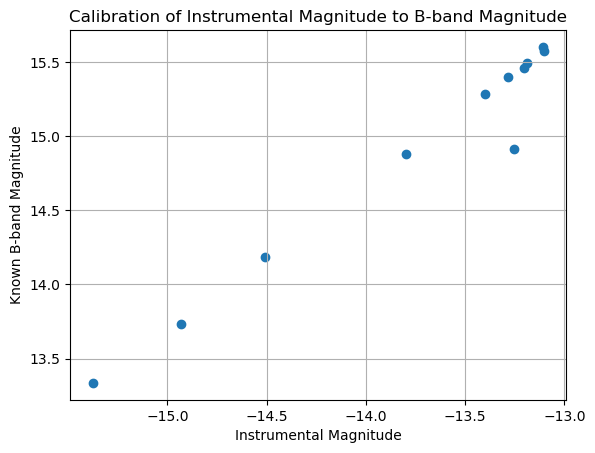

In [71]:
plt.scatter(df['Magnitude'], df['Bmag'])
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Known B-band Magnitude') #apparent
plt.title('Calibration of Instrumental Magnitude to B-band Magnitude')
plt.grid(True)
plt.show()

In [72]:
df['Offset'] = df['Bmag'] - df['Magnitude']

#averaging the offsets
average_offset = df['Offset'].mean()

#applying this offset to MRK 335's instrumental magnitude
mrk335_instrumental_mag = -13.7062977330628 
mrk335_true_mag = mrk335_instrumental_mag + average_offset

print(f"The apparent B-band magnitude of MRK 335 is approximately: {mrk335_true_mag}")

The true B-band magnitude of MRK 335 is approximately: 14.932276994209928


## Aperture Photometry for R-band

In [65]:
#Repeating the same procedure as above
# Defining the position for aperture photometry

fits_file = '/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-R.fit'  # Replace with the path to your FITS file
with fits.open(fits_file) as hdul:
    data = hdul[0].data 
positions = [(1048.9, 1027.15)] #retreived them from ds9 for mrk335

# Defining the target aperture and an annulus for background estimation
aperture = CircularAperture(positions, r=5.76)  # r=aperture radius 1.5* fwhm(1.5as=3.84 pixels)
annulus_aperture = CircularAnnulus(positions, r_in=7.68, r_out=11.52)  # r_in=2*FWHM(PIXELS) and r_out=3*FWHM(PIXELS) 

# Performing aperture photometry on the target
phot_table = aperture_photometry(data, aperture)

# Performing AP on the annulus to measure the background
annulus_phot_table = aperture_photometry(data, annulus_aperture)

# Calculating the mean background level (per pixel) in the annulus
# and then scaling it to the same size as the aperture
bkg_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area
bkg_sum = bkg_mean * aperture.area

# Subtracting the background from the aperture sum
phot_table['aperture_sum_bkg_subtracted'] = phot_table['aperture_sum'] - bkg_sum
print(phot_table['aperture_sum_bkg_subtracted'])

aperture_sum_bkg_subtracted
---------------------------
          447093.6549199385


In [66]:
aperture_sum=phot_table['aperture_sum_bkg_subtracted']
instrumental_magnitude = -2.5 * np.log10(aperture_sum)
print("Instrumental magnitude:", instrumental_magnitude)

Instrumental magnitude: aperture_sum_bkg_subtracted
---------------------------
         -14.12599626618869


In [101]:
df1=pd.read_csv('335_Sources_insmag_R.csv') #ra and dec in decimal degree
df1

,ApertureRA,ApertureDec,Magnitude,RAdeg,DEdeg,Rmag_x
0,1.639432,20.284393,-14.0572,1.639473,20.284443,14.557154
1,1.608548,20.278929,-14.4440,1.608451,20.279025,14.159441
2,1.594928,20.249256,-14.7274,1.594973,20.249377,13.868916
3,1.571666,20.235651,-13.6615,1.571584,20.235735,14.938536
4,1.574976,20.221445,-13.8350,1.574914,20.221500,14.755520
5,1.471766,20.220160,-13.6806,1.471657,20.220135,14.918292
6,1.632964,20.219028,-13.6142,1.633102,20.219067,14.989761
7,1.581393,20.203004,-14.1066,1.581405,20.202949,14.249559
8,1.583761,20.180670,-14.9381,1.583729,20.180644,13.651223
9,1.612884,20.141134,-14.1140,1.612889,20.141011,14.502264


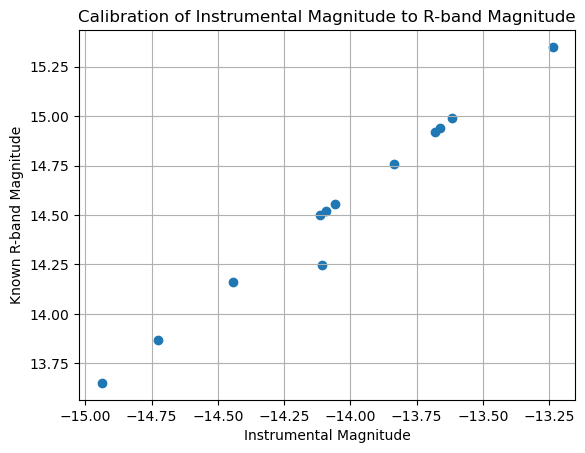

In [73]:
plt.scatter(df1['Magnitude'], df1['Rmag_x'])
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Known R-band Magnitude') #apparent
plt.title('Calibration of Instrumental Magnitude to R-band Magnitude')
plt.grid(True)
plt.show()

In [76]:
df1['Offset'] = df1['Rmag_x'] - df1['Magnitude']

#averaging the offsets
average_offset = df1['Offset'].mean()

#applying this offset to MRK 335's instrumental magnitude
mrk335_instrumental_mag = -14.12599626618869
mrk335_app_mag = mrk335_instrumental_mag + average_offset

print(f"The apparent R-band magnitude of MRK 335 is approximately: {mrk335_app_mag}")

The apparent R-band magnitude of MRK 335 is approximately: 14.454435900477975


## Aperture Photometry for V-band

In [85]:
#Repeating the same procedure as above
# Defining the position for aperture photometry

fits_file = '/Users/alizamustafa/Downloads/22_10_2023-copy/comb-335-V.fit' 
with fits.open(fits_file) as hdul:
    data = hdul[0].data 
positions = [(1093.3, 963.4)] #retreived them from ds9 for mrk335

# Defining the target aperture and an annulus for background estimation
aperture = CircularAperture(positions, r=6)  # r=aperture radius 1.5* fwhm(1.5as=3.84 pixels-->approx 4pix)
annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=25)  # r_in=2*FWHM(PIXELS) and r_out=3*FWHM(PIXELS) 

# Performing aperture photometry on the target
phot_table = aperture_photometry(data, aperture)

# Performing AP on the annulus to measure the background
annulus_phot_table = aperture_photometry(data, annulus_aperture)

# Calculating the mean background level (per pixel) in the annulus
# and then scaling it to the same size as the aperture
bkg_mean = annulus_phot_table['aperture_sum'] / annulus_aperture.area
bkg_sum = bkg_mean * aperture.area

# Subtracting the background from the aperture sum
phot_table['aperture_sum_bkg_subtracted'] = phot_table['aperture_sum'] - bkg_sum
print(phot_table['aperture_sum_bkg_subtracted'])

aperture_sum_bkg_subtracted
---------------------------
         331215.17035491887


In [86]:
aperture_sum=phot_table['aperture_sum_bkg_subtracted']
instrumental_magnitude = -2.5 * np.log10(aperture_sum)
print("Instrumental magnitude:", instrumental_magnitude)

Instrumental magnitude: aperture_sum_bkg_subtracted
---------------------------
        -13.800275550434176


In [72]:
df2=pd.read_csv('335_Sources_insmag_V.csv') #ra and dec in decimal degree
df2

,ApertureRA,ApertureDec,Magnitude,RAdeg,DEdeg,Vmag
0,1.639459,20.284393,-13.8061,1.639473,20.284443,14.928887
1,1.608483,20.278946,-14.1488,1.608451,20.279025,14.570581
2,1.534026,20.264923,-13.1601,1.533960,20.264936,15.578887
3,1.594895,20.249270,-14.4810,1.594973,20.249377,14.240785
4,1.574957,20.221454,-13.6849,1.574914,20.221500,15.025958
5,1.633045,20.219039,-13.2875,1.633102,20.219067,15.439362
6,1.504223,20.212716,-13.4480,1.504095,20.212757,15.277718
7,1.581494,20.202903,-13.7017,1.581405,20.202949,14.768952


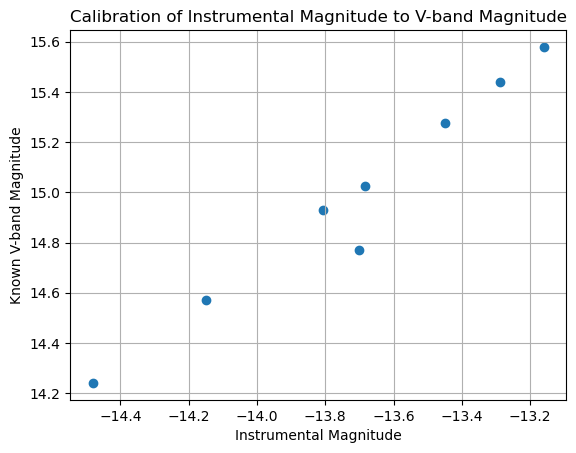

In [74]:
plt.scatter(df2['Magnitude'], df2['Vmag'])
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Known V-band Magnitude') #apparent
plt.title('Calibration of Instrumental Magnitude to V-band Magnitude')
plt.grid(True)
plt.show()

In [87]:
df2['Offset'] = df2['Vmag'] - df2['Magnitude']

#averaging the offsets
average_offset = df2['Offset'].mean()

#applying this offset to MRK 335's instrumental magnitude
mrk335_instrumental_mag = -13.8
mrk335_app_mag = mrk335_instrumental_mag + average_offset

print(f"The apparent V-band magnitude of MRK 335 is approximately: {mrk335_app_mag}")

The apparent V-band magnitude of MRK 335 is approximately: 14.893653750000002


- As the apperture size increases the instrumental magnitude increases while, the apparent magnitude decreases.